# Support Vector Machines (SVM) Introductory Overview

Support Vector Machines are based on the concept of decision planes that define decision boundaries. A decision plane is one that separates between a set of objects having different class memberships. A schematic example is shown in the illustration below. In this example, the objects belong either to class GREEN or RED. The separating line defines a boundary on the right side of which all objects are GREEN and to the left of which all objects are RED. Any new object (white circle) falling to the right is labeled, i.e., classified, as GREEN (or classified as RED should it fall to the left of the separating line).

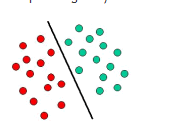

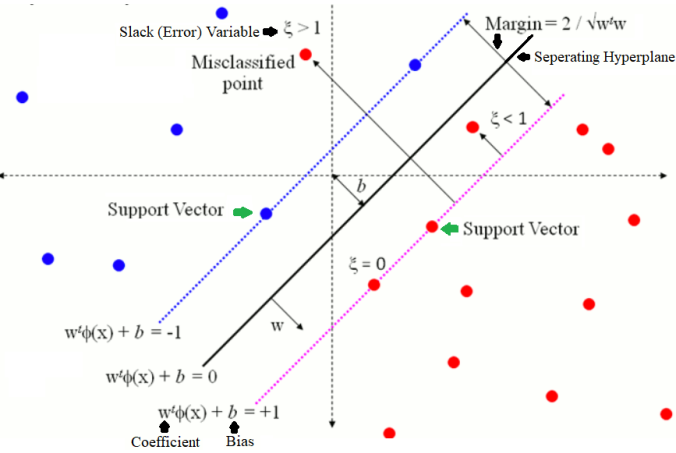

- Given a (training) dataset consisting of positive and negative class instances.
- Objective is to find a maximum-margin classifier, in terms of a hyper-plane (the vectors w and b) that separates the positive and negative instances (in the training dataset).
- If the dataset is noisy (with some overlap in positive and negative samples), there will be some error in classifying them with the hyper-plane.
- In the latter case the objective will be to minimize the errors in classification along with maximizing the margin and the problem becomes a soft-margin SVM (as opposed to the hard margin SVM without slack variables).
- A slack variable per training point is introduced to include the classification errors (for the miss-classified points in the training dataset) in the objective, this can also be thought of adding regularization.
- Hence the optimization problem is often solved in the dual space by converting the minimization to a maximization problem 
- If the dataset is not linearly separable, the kernel trick is used to conceptually map the datapoints to some higher-dimensions only by computing the (kernel) gram matrix /  dot-product of the datapoints (the matrix needs to positive semi-definite as per Mercer’s theorem).
- Some popular kernel functions are the linear, polynomial, Gaussian (RBF, corresponding to the infinite dimensional space) kernels.

# SVM for Amzon fine food review with 25k Datapoints

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# Objective :-

Here we have to apply Radial Basis Function classfication Alogoritm in various method for AMZON fine food review and check which 
featurization is good for the alogorithm .

1). Train,CV and test the data.

2). Here we are going to use first SGD classifier for all featurization , after getting the best featuriztion for linear SVM ,we will use RBF SVM on that featrization 

3). Here we are going to perform Both GridsearchCV and RandomsearchCV for cossvalidation for finding best c and gamma.


In [1]:
import os
os.getcwd()

'C:\\Users\\Nicky\\Desktop\\my work\\SVM'

In [2]:
#Importing the nessary library for this assignement .
import numpy as np
import pandas as pd
import sqlite3 as sql
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#Peforemance measurment techniques
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm #for Instantly make your loops show a smart progre
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [3]:
#Functions to save objects for later use and retireve it
def export(obj,filename):
    pickle.dump(obj,open(filename+".dmp","wb"))
def import1(filename):
    temp = pickle.load(open(filename+".dmp","rb"))
    return temp

# Loading the cleaned data

In [4]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
food1 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
food1.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'june saw charm group rose begin droop pep ch...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [5]:
food1.groupby('Score').count()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
Score,,,,,,,,,,,
negative,57107,57107,57107,57107,57107,57107,57107,57107,57107,57107,57107
positive,336824,336824,336824,336824,336824,336824,336824,336824,336824,336824,336824


In [6]:
def label(x):
    if x == "positive":
        return 1
    else:
        return 0
food1["Score"] = food1["Score"].map(label) #Map all the scores as the function polarity i.e. positive or negative
food1=food1.sample(28000)


In [7]:
food1.groupby('Score').head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
260516,400047,400048,B002IEVJRY,A2VYSDQ4Q7B2TC,Grace,0,0,1,1332460800,Can't complain about this coffee; good size an...,There's nothing particularly wonderful about c...,b'there noth particular wonder can coffe opini...
120534,487017,487018,B000PDWBKO,A2IW5P1NA5EK60,C. Dougherty,0,0,1,1328054400,"Yummy popcorn, perfect for a whirley pop!",I purchased these 8 oz portion packs around a ...,b'purchas portion pack around month ago time p...
25988,330891,330892,B0007IQQWQ,A1UOJL3X5PVPSP,Speller...,0,0,0,1340323200,"It's COLOMBIAN, not columbian...",How do you expect to get to someone's liking i...,b'expect get someon like not even know spell n...
297586,236544,236545,B003LWOS7A,AUCEUTMJBY8MP,S. Linton,1,2,0,1332979200,Terrible Flavor,I'm amazed that this is getting any positive r...,b'amaz get posit review make wonder kind tea p...


In [8]:
#help(food1.sample)
food1.sort_values('Time',inplace=True)

# Bag of Words (BoW)

In [19]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1['CleanedText'].values,food1['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#normalize the data
X_train = preprocessing.normalize(X_train) #normalization of data has better accurac than mean centering and scalling
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#normalize the data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 358448)
Test Data Size:  (7500, 358448)


In [13]:
from sklearn.model_selection import TimeSeriesSplit
timesplit = TimeSeriesSplit(n_splits=3)

# GridSearchCV

In [65]:
%%time
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
gsv = GridSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   46.5s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 91.34%
Wall time: 49.2 s


Wall time: 0 ns
Accuracy on test data set: 91.440%
Precision on test data set: 0.926
Recall on test data set: 0.976
F1-Score on test data set: 0.950
Non Zero weights: 772417
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]



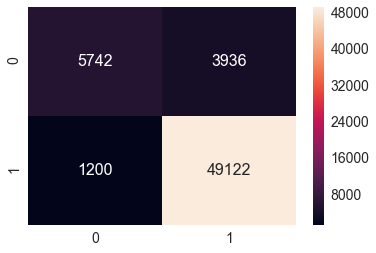

In [66]:
%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = SGDClassifier(alpha= 1e-05,loss='hinge')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# From BOW 60K datapaoint correctly calssified 54764 with 91.273% accuracy and f1 score of .950

# RandomizedSearchCV

In [29]:
from sklearn.model_selection import RandomizedSearchCV
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
bi_rsv = RandomizedSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
bi_rsv.fit(X_train,y_train)
export(bi_rsv,"bi_rsv")
print("Best HyperParameter: ",bi_rsv.best_params_)
print("Best Accuracy: %.2f%%"%(bi_rsv.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.8s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 91.33%


Wall time: 0 ns
Accuracy on test data set: 91.567%
Precision on test data set: 0.930
Recall on test data set: 0.973
F1-Score on test data set: 0.951
Non Zero weights: 774036
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]



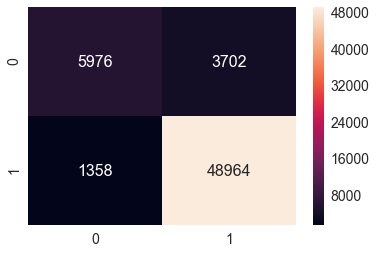

In [30]:
%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = SGDClassifier(alpha= 1e-05, loss='hinge')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TF-IDF

In [14]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1['CleanedText'].values,food1['Score'].values,test_size=0.3,shuffle=False)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf_vec.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf_vec.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (140000, 1567326)
Test Data Size:  (60000, 1567326)
Wall time: 35 s


# GridSearchCV

In [32]:
%%time
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
gsv = GridSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   46.4s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 91.32%
Wall time: 47.8 s


Wall time: 0 ns
Accuracy on test data set: 91.490%
Precision on test data set: 0.925
Recall on test data set: 0.978
F1-Score on test data set: 0.951
Non Zero weights: 804443
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]



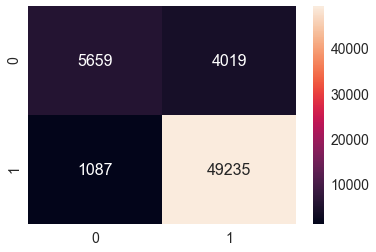

In [33]:
%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = SGDClassifier(alpha= 1e-05,loss='hinge')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# RandomizedSearchCV

In [34]:
from sklearn.model_selection import RandomizedSearchCV
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
tfidf_rsv = RandomizedSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
tfidf_rsv.fit(X_train,y_train)
export(tfidf_rsv,"tfidf_rsv")
print("Best HyperParameter: ",tfidf_rsv.best_params_)
print("Best Accuracy: %.2f%%"%(tfidf_rsv.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.0s finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 85.48%


Wall time: 0 ns
Accuracy on test data set: 85.817%
Precision on test data set: 0.856
Recall on test data set: 0.999
F1-Score on test data set: 0.922
Non Zero weights: 800488
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]



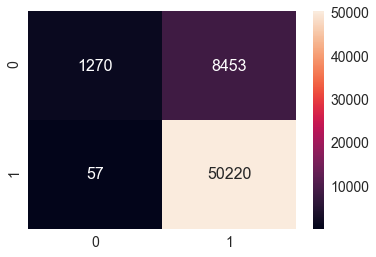

In [16]:
%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = SGDClassifier(alpha= 0.0001,loss='hinge')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Clean the text with no stem for avgw2v and tfidf-w2v model

In [36]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"that'll", 'she', 'both', 'there', 'couldn', 'being', 'didn', 'me', 'only', 'no', 'such', 'by', "wouldn't", 'up', 'where', 'to', 'just', 'you', "mightn't", 'doing', 'off', 're', 'and', 'into', 'how', "you've", 'while', 'shouldn', 'her', "hasn't", 's', 'needn', 'has', 'some', 'about', 'from', 'in', 'over', 'which', 'until', 'am', 'doesn', 'out', 'at', 'will', 'himself', 'then', 'more', "won't", 'weren', 'after', 'aren', 'very', 'i', 'myself', "mustn't", 'shan', 'their', 'all', 'against', 'other', 'm', 'his', 'between', 'be', 'them', "aren't", 'same', 'they', 'itself', 'y', 'above', 'our', 'does', 'when', 'was', "you'll", 't', 'it', 'those', 'mightn', 'so', 'who', 'too', 'ain', 'before', "isn't", "it's", 'as', 'been', 'yours', 'ourselves', "should've", 'down', 'if', 'for', 'haven', 'o', "you'd", 'do', 'ma', 'this', 'any', 'are', 'these', 'but', "shouldn't", 'own', 'that', 'below', 'the', 'of', 'd', "shan't", 'were', 'have', 'few', 'had', 'mustn', 've', 'whom', 'my', "doesn't", 'hers', '

# Spliting the train and test data before running any model

In [37]:
X_train, X_test, y_train, y_test = train_test_split(food1['Text'].values,food1['Score'].values,test_size=0.3,shuffle=False)

In [38]:
i=0
train_list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_list_of_sent.append(filtered_sentence)

In [39]:
print(len(train_list_of_sent))
export(train_list_of_sent,'train_list_of_sent')

140000


In [40]:
i=0
Test_list_of_sent=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    Test_list_of_sent.append(filtered_sentence)

In [41]:
print(len(Test_list_of_sent))
export(Test_list_of_sent,'Test_list_of_sent')

60000


# w2v model

Here we are using the google trained w2v model.
1. for using the w2v model , minimum 16 GB RAM required . so please carefull about it 

In [42]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

D:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Avg w2v model

In [44]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in train_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))
export(train_sent_vectors,'train_sent_vectors')

140000
300
Wall time: 2min


In [45]:
train_sent_vectors = np.array(train_sent_vectors)

In [46]:
np.isnan(train_sent_vectors).any()

False

In [47]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
Test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in Test_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    Test_sent_vectors.append(sent_vec)
print(len(Test_sent_vectors))
print(len(Test_sent_vectors[0]))
export(Test_sent_vectors,'Test_sent_vectors')

60000
300
Wall time: 53.5 s


In [48]:
Test_sent_vectors = np.array(Test_sent_vectors)

In [49]:
np.isnan(Test_sent_vectors).any()

False

# GridSearchCV

In [50]:
%%time
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
gsv = GridSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(train_sent_vectors,y_train)
export(gsv,"gsv_W2V")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   51.2s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 86.96%
Wall time: 53.9 s


Accuracy on test data set: 86.253%
Precision on test data set: 0.862
Recall on test data set: 0.995
F1-Score on test data set: 0.924
Non Zero weights: 300
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]

Wall time: 1.08 s


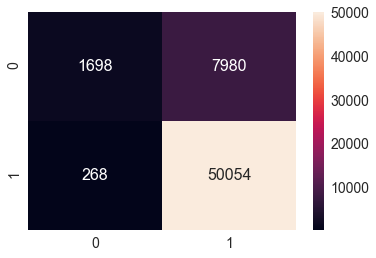

In [51]:
%%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

alogo = SGDClassifier(alpha= 1e-05, loss='hinge')
alogo.fit(train_sent_vectors,y_train)
y_pred = alogo.predict(Test_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# RandomizedSearchCV

In [52]:
from sklearn.model_selection import RandomizedSearchCV
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
Avgw2v_rsv = RandomizedSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
Avgw2v_rsv.fit(train_sent_vectors,y_train)
export(tfidf_rsv,"tfidf_rsv")
print("Best HyperParameter: ",Avgw2v_rsv.best_params_)
print("Best Accuracy: %.2f%%"%(Avgw2v_rsv.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.4s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 88.11%


Accuracy on test data set: 88.080%
Precision on test data set: 0.890
Recall on test data set: 0.979
F1-Score on test data set: 0.932
Non Zero weights: 300
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]

Wall time: 1.06 s


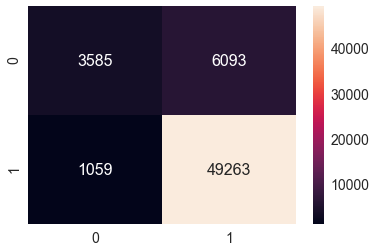

In [53]:
%%time
import seaborn as sns
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

alogo = SGDClassifier(alpha= 1e-05,loss='hinge')
alogo.fit(train_sent_vectors,y_train)
y_pred = alogo.predict(Test_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TFIDF-W2V

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
tfidf = TfidfVectorizer(ngram_range=(1,1)) #Using bi-grams
tfidf_vec = tfidf.fit_transform(X_train)

In [55]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [56]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            #print()
            sent_vec += (vec * tf_idf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████| 140000/140000 [03:32<00:00, 660.37it/s]


Wall time: 3min 32s


In [57]:
train_tfidf_sent_vectors = np.array(train_tfidf_sent_vectors)

In [58]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='median')
train_sent_vectors = mean_imputer.fit_transform(train_tfidf_sent_vectors)

In [59]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            #print()
            sent_vec += (vec * tf_idf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 60000/60000 [01:34<00:00, 636.14it/s]


Wall time: 1min 34s


In [60]:
test_tfidf_sent_vectors = np.array(test_tfidf_sent_vectors)

In [61]:
np.isnan(test_tfidf_sent_vectors).any()

False

# GridSearchCV

In [62]:
%%time
algo = SGDClassifier()
param_grid = {'alpha':[10000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,.00001]}
gsv = GridSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(train_sent_vectors,y_train)
export(gsv,"gsv_W2V")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   51.5s finished


Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 87.48%
Wall time: 54.2 s


Accuracy on test data set: 86.902%
Precision on test data set: 0.895
Recall on test data set: 0.956
F1-Score on test data set: 0.924
Non Zero weights: 300
Confusion Matrix of test data set:
 [ [TN  FN]
 [FP TP] ]

Wall time: 1.08 s


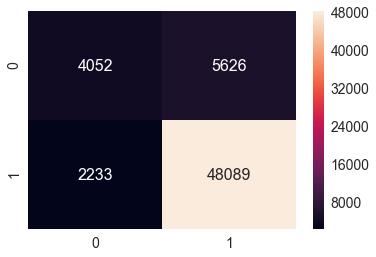

In [63]:
%%time
import seaborn as sns
#Testing Accuracy on Test data


alogo = SGDClassifier(alpha= 1e-05,loss='hinge')
alogo.fit(train_sent_vectors,y_train)
y_pred = alogo.predict(test_tfidf_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Pefermance table For SGD classifer:- 

In [19]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","hyper parameter/ alpha", "Train Accuracy","Test Accuracy","F1-Score"]

x.add_row(["BOW", '1e-05' , "91.33%" , "91.567%",0.951])
x.add_row(["TF-IDF","1e-05", "91.32%" , "91.490%",0.955])
x.add_row(["Avg w2v", "1e-05", "86.96%" , "86.253%",0.924])
x.add_row(["Tfidf-w2v", "1e-05", "87.48%" , "86.902%",0.930])


print(x)

+-----------+------------------------+----------------+---------------+----------+
|   Model   | hyper parameter/ alpha | Train Accuracy | Test Accuracy | F1-Score |
+-----------+------------------------+----------------+---------------+----------+
|    BOW    |         1e-05          |     91.33%     |    91.567%    |  0.951   |
|   TF-IDF  |         1e-05          |     91.32%     |    91.490%    |  0.955   |
|  Avg w2v  |         1e-05          |     86.96%     |    86.253%    |  0.924   |
| Tfidf-w2v |         1e-05          |     87.48%     |    86.902%    |   0.93   |
+-----------+------------------------+----------------+---------------+----------+


# From the above test on the SGD we found that BOW is the best vectorization where we are gettting higher accuracy , so we are going to test RBF SVM on the vectorization

# RBF SVM parameters

- Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

- The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words``C`` behaves as a regularization parameter in the SVM

- The behavior of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.

- When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes

http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html 

# GridSearchCV on BOW using SVM

In [10]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1['CleanedText'].values,food1['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#normalize the data
X_train = preprocessing.normalize(X_train) #normalization of data has better accurac than mean centering and scalling
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#normalize the data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (19600, 393864)
Test Data Size:  (8400, 393864)


In [14]:
%%time
algo = SVC()
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
rsv=RandomizedSearchCV(algo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
rsv.fit(X_train,y_train)
##export(gsv,"gsv_bigram")
print("Best HyperParameter: ",rsv.best_params_)
print("Best Accuracy: %.2f%%"%(rsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.9min finished


Best HyperParameter:  {'gamma': 0.1, 'C': 100.0}
Best Accuracy: 89.90%
Wall time: 32min


# Missclassification error vs hyperparameter 

In [86]:
rsv.cv_results_

{'mean_fit_time': array([ 14.79251266,  18.76607339,  20.10614983,  27.99193438,
        116.64700508, 368.98277132, 156.17493256, 156.63962603,
         75.64032634, 134.6477015 ]),
 'std_fit_time': array([ 11.8021814 ,  14.3303525 ,  16.32349551,  22.82567647,
        130.38171436, 369.33541522, 188.78408901, 189.12042936,
         76.03163473, 115.4835176 ]),
 'mean_score_time': array([ 5.20563118,  8.34814405,  8.84517264, 10.04090762, 18.98808606,
        35.76104546, 17.23965279, 17.2239852 , 16.89629984, 22.41128182]),
 'std_score_time': array([ 2.96002989,  4.65916787,  5.41605271,  5.36684784,  7.21122341,
        11.86316452,  6.40959223,  6.43883661,  6.39750975,  6.18451488]),
 'param_gamma': masked_array(data=[1e-07, 1e-07, 1e-09, 1e-05, 0.1, 100.0, 1e-05, 1e-05,
                    0.1, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_C': masked_

In [76]:
test_score = rsv.cv_results_['mean_test_score']
MSE = 1-test_score
MSE

array([0.22312925, 0.1485034 , 0.1485034 , 0.1485034 , 0.10095238,
       0.1485034 , 0.1014966 , 0.1014966 , 0.10170068, 0.11578231])

In [77]:
df = pd.DataFrame({'MSE': [0.22312925, 0.1485034 , 0.1485034 , 0.1485034 , 0.10095238,0.1485034 , 0.1014966 , 0.1014966 , 0.10170068, 0.11578231] ,'gamma': [1e-07, 1e-07, 1e-09, 1e-05, 0.1, 100.0, 1e-05, 1e-05, 0.1, 1.0], 'C': [1000000000.0, 0.1, 0.01, 10.0, 100.0, 10.0, 10000000.0, 10000000000.0,10.0, 10000.0]})
df

,MSE,gamma,C
0,0.223129,1.000000e-07,1.000000e+09
1,0.148503,1.000000e-07,1.000000e-01
2,0.148503,1.000000e-09,1.000000e-02
3,0.148503,1.000000e-05,1.000000e+01
4,0.100952,1.000000e-01,1.000000e+02
5,0.148503,1.000000e+02,1.000000e+01
6,0.101497,1.000000e-05,1.000000e+07
7,0.101497,1.000000e-05,1.000000e+10
8,0.101701,1.000000e-01,1.000000e+01
9,0.115782,1.000000e+00,1.000000e+04


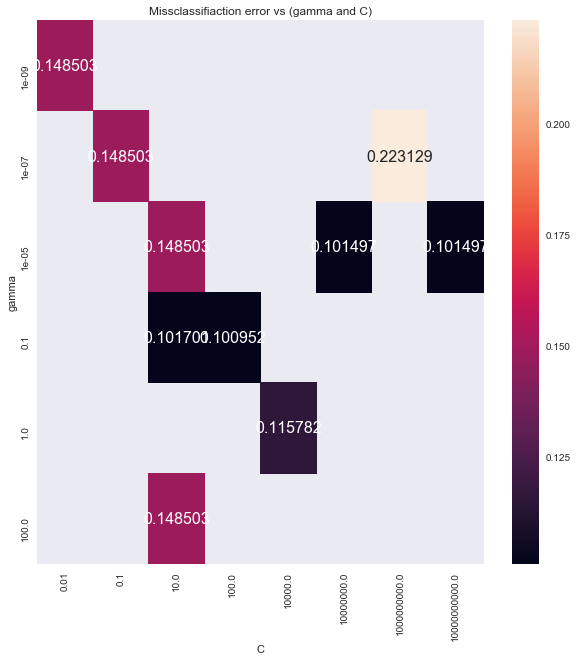

In [84]:
result = df.pivot(index='gamma', columns='C', values='MSE')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(result,ax=ax,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title("Missclassifiaction error vs (gamma and C)")
plt.show()

From the above plot we can able to find that we are getting missclassifiaction error value lower as 0.100952 during gamma 0.1 and c 100 . For that reason our best hyperparameters are gamma=01 and c=100

Wall time: 0 ns
Accuracy on test data set: 90.298%
Precision on test data set: 0.923
Recall on test data set: 0.965
F1-Score on test data set: 0.944
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]



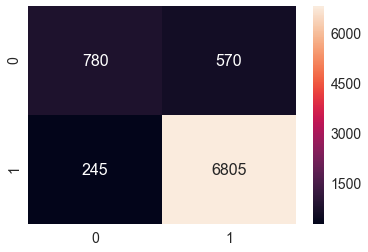

In [85]:
%time
import seaborn as sns
#Testing Accuracy on Test data

alogo = SVC(gamma= 0.1,C=100.0)
alogo.fit(X_train,y_train)
y_pred = alogo.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusion :-

1) we can able to find that SVM is working very farily for predicting the class level with most accuracy .

2) But SVM alogotrithm is very much time consuming alogorithm if you donot know about the kernel to be used . For find the best kernel through cv is very much time complex .

3) SVM with RBF kernel the separating plane exists in another space - a result of kernel transformation of the original space. Its coefficients are not directly related to the input space. Hence we can't get the feature importance